# pytorch practice

In [1]:
import pandas as pd
import numpy as  np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,  accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot  as plt
%matplotlib inline

***白ワイン***のデータセットを使用する。

[Wine Quality Data Set ](https://archive.ics.uci.edu/ml/datasets/wine+quality)

各ワインのデータは以下の11種類の特徴量からなる。
- 1 - fixed acidity 
- 2 - volatile acidity 
- 3 - citric acid 
- 4 - residual sugar 
- 5 - chlorides 
- 6 - free sulfur dioxide 
- 7 - total sulfur dioxide 
- 8 - density 
- 9 - pH 
- 10 - sulphates 
- 11 - alcohol 

各ワインには0から10の品質スコアが付与されており、11種類の特徴量を元にワインの品質を高品質（ワインのqualityが6以上）、低品質（ワインのqualityが6未満）の2値にして予測する2クラス分類問題を考える。

In [3]:
# 白ワインデータセットの読み込み
wine = pd.read_csv("winequality-white.csv", sep=";")

In [4]:
# 特徴量
X=wine[ ['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates','alcohol']].values

# 正解ラベルを1（高品質：ワインのqualityが6以上）か0（低品質：ワインのqualityが6未満）とする
y=wine['quality'].values
y = (y>=6).astype(np.int) 
print(np.sum(y==1, axis=0)) # 高品質ワインデータの数
print(np.sum(y==0, axis=0)) # 低品質ワインデータの数

3258
1640


## pytorchのインポート

In [5]:
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## 2.データの観察


In [6]:
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


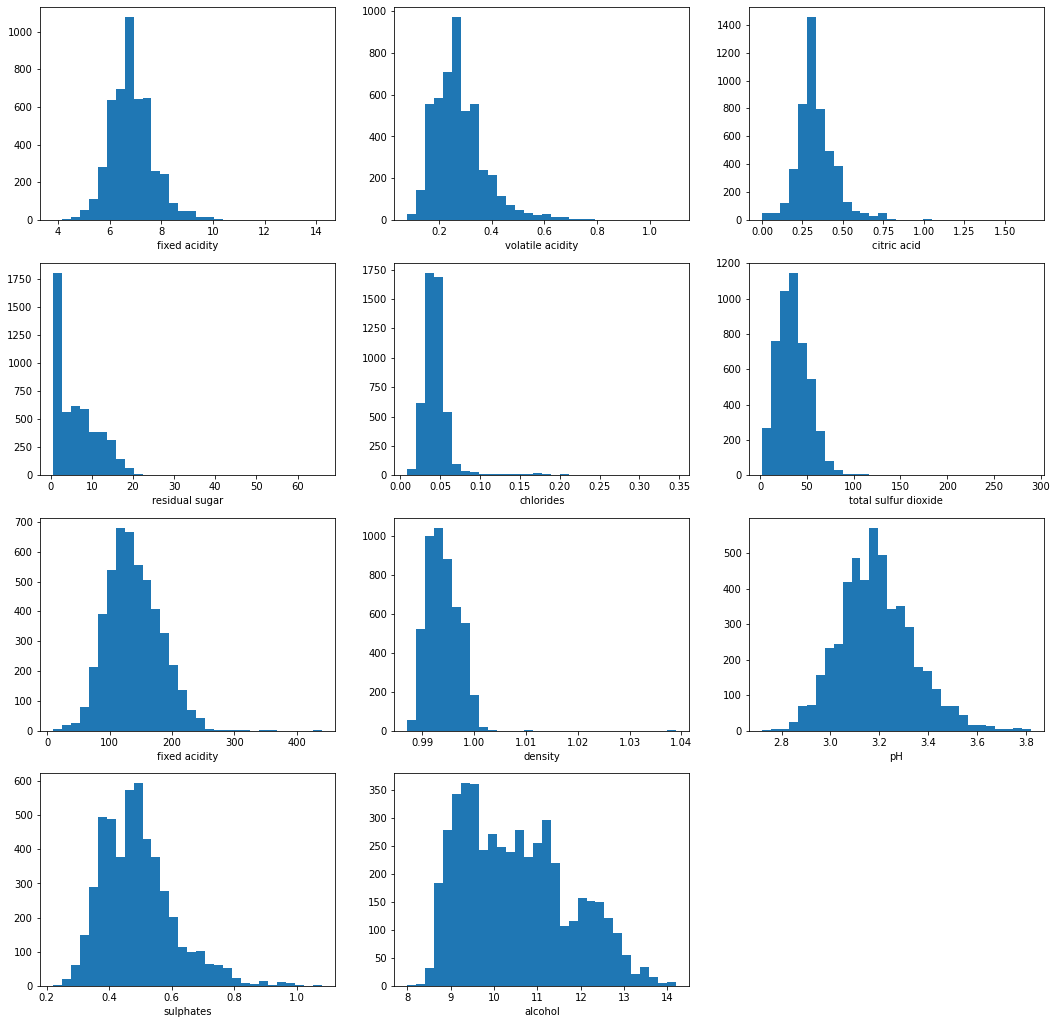

In [61]:
fig = plt.figure(figsize = (18,18))
n_bins = 30

ax1 = fig.add_subplot(4,3,1)
ax1.hist(wine[wine.columns.values[0]], n_bins)
ax1.set(xlabel = wine.columns.values[0])

ax2 = fig.add_subplot(4,3,2)
ax2.hist(wine[wine.columns.values[1]], n_bins)
ax2.set(xlabel = wine.columns.values[1])

ax3 = fig.add_subplot(4,3,3)
ax3.hist(wine[wine.columns.values[2]], n_bins)
ax3.set(xlabel = wine.columns.values[2])

ax4 = fig.add_subplot(4,3,4)
ax4.hist(wine[wine.columns.values[3]], n_bins)
ax4.set(xlabel = wine.columns.values[3])

ax5 = fig.add_subplot(4,3,5)
ax5.hist(wine[wine.columns.values[4]], n_bins)
ax5.set(xlabel = wine.columns.values[4])

ax6 = fig.add_subplot(4,3,6)
ax6.hist(wine[wine.columns.values[5]], n_bins)
ax6.set(xlabel = wine.columns.values[6])

ax7 = fig.add_subplot(4,3,7)
ax7.hist(wine[wine.columns.values[6]], n_bins)
ax7.set(xlabel = wine.columns.values[0])

ax8 = fig.add_subplot(4,3,8)
ax8.hist(wine[wine.columns.values[7]], n_bins)
ax8.set(xlabel = wine.columns.values[7])

ax9 = fig.add_subplot(4,3,9)
ax9.hist(wine[wine.columns.values[8]], n_bins)
ax9.set(xlabel = wine.columns.values[8])

ax10 = fig.add_subplot(4,3,10)
ax10.hist(wine[wine.columns.values[9]], n_bins)
ax10.set(xlabel = wine.columns.values[9])

ax11 = fig.add_subplot(4,3,11)
ax11.hist(wine[wine.columns.values[10]], n_bins)
ax11.set(xlabel = wine.columns.values[10])

plt.show()

## 3.前処理

In [7]:
# 正規化
def mean_norm(df_input):
    return df_input.apply(lambda x: (x-x.mean())/ x.std(), axis=0)

# テンソル化、訓練データ、検証データに分割
n = 4500
m = 200
train_X = torch.tensor(mean_norm(wine.iloc[:n, 1:-1]).values).float()
train_t = torch.tensor(y[:n]).float()
valid_X = torch.tensor(mean_norm(wine.iloc[n:n+m,1:-1]).values).float()
valid_t = torch.tensor(y[n:n+m]).float()
test_X = torch.tensor(mean_norm(wine.iloc[n+m:,1:-1]).values).float()
test_t = torch.tensor(y[n+m:]).float()

print('train_X : ', train_X.shape)
print('train_t : ', train_t.shape)
print('valid_X : ', valid_X.shape)
print('valid_t : ', valid_t.shape)
print('test_X : ', test_X.shape)
print('test_t : ', test_t.shape)

# Datasetの作成
train_dataset = TensorDataset(train_X, train_t)
valid_dataset = TensorDataset(valid_X, valid_t)

index = 0
print(train_dataset.__getitem__(index))

# DataLoaderの作成

batch_size = 40
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


train_X :  torch.Size([4500, 10])
train_t :  torch.Size([4500])
valid_X :  torch.Size([200, 10])
valid_t :  torch.Size([200])
test_X :  torch.Size([198, 10])
test_t :  torch.Size([198])
(tensor([-0.0621,  0.2005,  2.7822, -0.0475,  0.5777,  0.7185,  2.2906, -1.2362,
        -0.3441, -1.3689]), tensor(1.))


## 4.ネットワークの定義

In [8]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net,self).__init__()
        
        self.fc1 = nn.Linear(10, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

        
    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        
        return(x)

net = Net()
print(net)

Net(
  (fc1): Linear(in_features=10, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
)


## 5.ネットワークの学習


In [126]:
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr = 0.01, weight_decay = 1e-8)

train_loss_list = []
train_accuracy_list = []
valid_loss_list = []
valid_accuracy_list = []

num_epoch = 1000

for epoch in range(num_epoch):
    # 訓練
    net.train()
    running_loss = 0.0
    correct = 0

    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = net(inputs).view(-1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = torch.round(outputs)
        correct += sum(preds == labels).item()  

    train_loss_list.append(running_loss / n)
    train_accuracy_list.append(correct / n)
  
    if epoch % 100 == 99:
        print('epoch:', epoch + 1, 'train loss = ', running_loss / n, 'train accuracy = ', round(correct * 100 / n), '%')
  
    # 検証
    net.eval()
    running_loss = 0.0
    correct = 0.0
  
    with torch.no_grad():
        for inputs, labels in  valid_dataloader:
        outputs = net(inputs).view(-1)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        preds = torch.round(outputs)
        correct += sum(preds == labels).item()

    valid_loss_list.append(running_loss / m)
    valid_accuracy_list.append(correct / m)
  
    if epoch % 100 == 99:
        print('epoch:', epoch + 1, 'valid loss = ', running_loss / m, 'valid accuracy = ', round(correct * 100 / m), '%')


epoch: 100 train loss =  0.011422493272357517 train accuracy =  79 %
epoch: 100 valid loss =  0.010661076232790946 valid accuracy =  82 %
epoch: 200 train loss =  0.010320594088898764 train accuracy =  81 %
epoch: 200 valid loss =  0.010755825862288475 valid accuracy =  80 %
epoch: 300 train loss =  0.00921629379524125 train accuracy =  83 %
epoch: 300 valid loss =  0.013777911067008972 valid accuracy =  76 %
epoch: 400 train loss =  0.008157355235682593 train accuracy =  86 %
epoch: 400 valid loss =  0.01321874275803566 valid accuracy =  80 %
epoch: 500 train loss =  0.007100405610269971 train accuracy =  88 %
epoch: 500 valid loss =  0.017921569645404815 valid accuracy =  71 %
epoch: 600 train loss =  0.0062074359671937095 train accuracy =  90 %
epoch: 600 valid loss =  0.027406814992427826 valid accuracy =  64 %
epoch: 700 train loss =  0.005591572908891572 train accuracy =  91 %
epoch: 700 valid loss =  0.028267507553100587 valid accuracy =  64 %
epoch: 800 train loss =  0.00429023

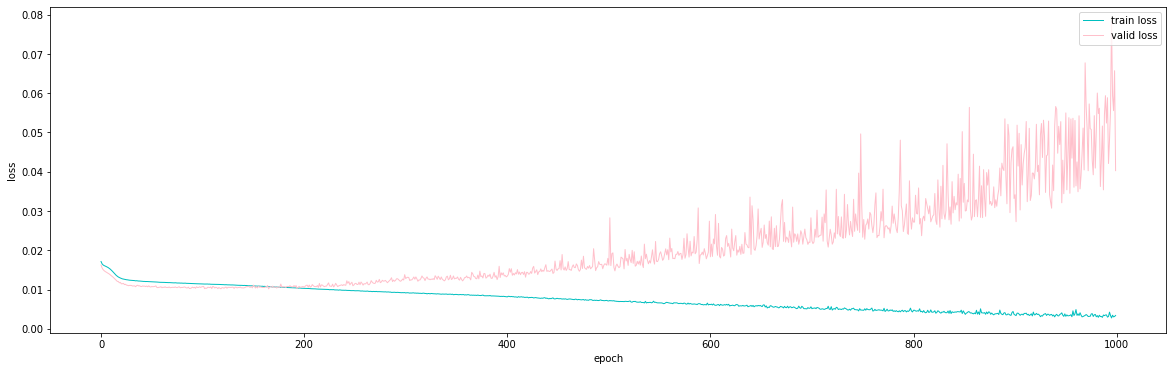

In [127]:
plt.figure(figsize = (20,6))
plt.plot(train_loss_list, color = 'c', linewidth = 1, label = 'train loss')
plt.plot(valid_loss_list, color = 'pink', linewidth = 1, label = 'valid loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc = 'upper right')
plt.show()

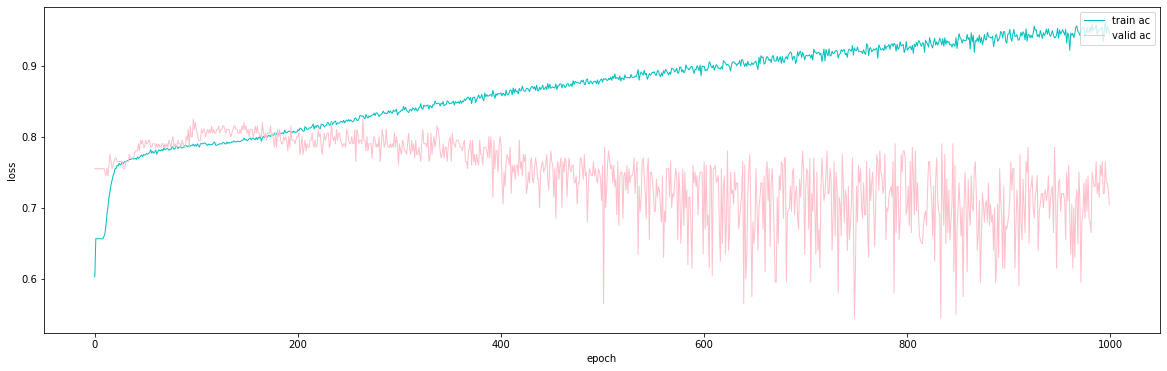

In [128]:
plt.figure(figsize = (20,6))
plt.plot(train_accuracy_list, color = 'c', linewidth = 1, label = 'train ac')
plt.plot(valid_accuracy_list, color = 'pink', linewidth = 1, label = 'valid ac')
plt.xlabel('ac')
plt.ylabel('loss')
plt.legend(loc = 'upper right')
plt.show()

誤差関数にはBCELoss、最適化関数にはSGDを選んだが、途中から訓練データの正解率は100パーセントに近くなっている一方でバリデーションデータの正解率は伸び悩んでおり、明らかに過学習してしまっている。これは訓練データ数が少ないためと考えられる。

## 評価

In [129]:
net.eval()
with torch.no_grad():
  outputs = net(test_X).view(-1)
preds = torch.round(outputs).detach().numpy()
cm = confusion_matrix(test_t, preds)
print(cm)

[[ 29  16]
 [ 36 117]]


## 改善


In [43]:
from sklearn.model_selection import KFold

n = 4500
train_X = torch.tensor(mean_norm(wine.iloc[:n, 1:-1]).values).float()
train_t = torch.tensor(y[:n]).float()
test_X = torch.tensor(mean_norm(wine.iloc[n:, 1:-1]).values).float()
test_t = torch.tensor(y[n:]).float()
train_loss_list = []
train_accuracy_list = []
valid_loss_list = []
valid_accuracy_list = []

net = Net()
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr = 0.01, weight_decay = 1e-8)
num_epoch = 4000
kf = KFold(n_splits = 5, shuffle = True)

for epoch in range(num_epoch):
    for i, (train_index, valid_index) in enumerate(kf.split(train_X)):
        # 訓練
        net.train()
        optimizer.zero_grad()
        outputs = net(train_X[train_index]).view(-1)
        loss = criterion(outputs, train_t[train_index])
        loss.backward()
        optimizer.step()
        running_loss = loss.item()
        preds = torch.round(outputs)
        correct = sum(preds == train_t[train_index]).item()
        if i == 4:
            train_loss_list.append(running_loss)
            train_accuracy_list.append(correct / len(train_index))
            if epoch % 100 == 99:
                print('epoch: ', epoch + 1, 'train loss: ', running_loss, 'train accuracy: ', round(correct * 100 / len(train_index)) , '%')
                
        # 検証
        net.eval()
        with torch.no_grad():
            outputs = net(train_X[valid_index]).view(-1)
            loss = criterion(outputs, train_t[valid_index])
            running_loss = loss.item()
            preds = torch.round(outputs)
            correct = sum(preds == train_t[valid_index]).item()
            if i == 0:
                valid_loss_list.append(running_loss)
                valid_accuracy_list.append(correct / len(valid_index))
                if epoch % 100 == 99:
                    print('epoch: ', epoch + 1, 'valid loss: ', running_loss, 'valid accuracy: ', round(correct * 100 / len(valid_index)), '%')

epoch:  100 valid loss:  0.6263289451599121 valid accuracy:  67 %
epoch:  100 train loss:  0.6305380463600159 train accuracy:  66 %
epoch:  200 valid loss:  0.6065748929977417 valid accuracy:  65 %
epoch:  200 train loss:  0.5994950532913208 train accuracy:  65 %
epoch:  300 valid loss:  0.5466766357421875 valid accuracy:  71 %
epoch:  300 train loss:  0.5402423143386841 train accuracy:  72 %
epoch:  400 valid loss:  0.5173122882843018 valid accuracy:  73 %
epoch:  400 train loss:  0.5101857781410217 train accuracy:  75 %
epoch:  500 valid loss:  0.4973052740097046 valid accuracy:  75 %
epoch:  500 train loss:  0.4870309829711914 train accuracy:  76 %
epoch:  600 valid loss:  0.4899897575378418 valid accuracy:  75 %
epoch:  600 train loss:  0.48499491810798645 train accuracy:  76 %
epoch:  700 valid loss:  0.48726391792297363 valid accuracy:  78 %
epoch:  700 train loss:  0.48131033778190613 train accuracy:  77 %
epoch:  800 valid loss:  0.45771026611328125 valid accuracy:  78 %
epoch:

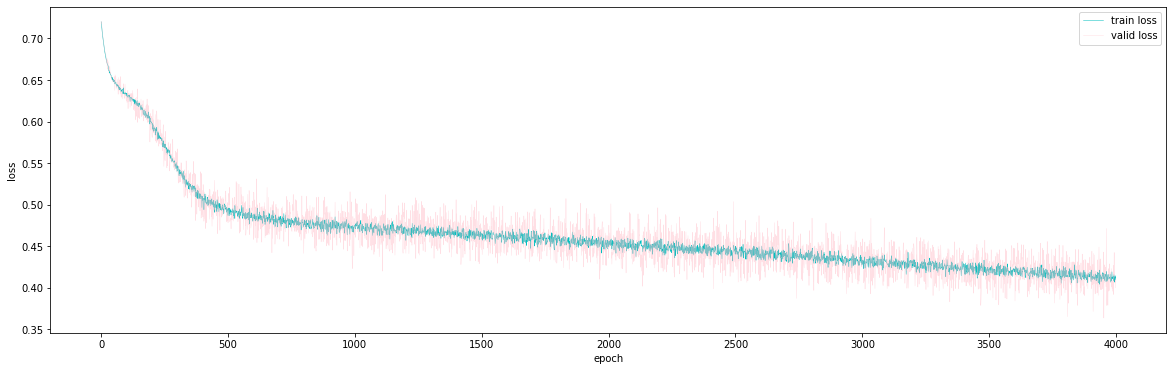

In [44]:
plt.figure(figsize = (20,6))
plt.plot(train_loss_list, color = 'c', linewidth = 0.5, label = 'train loss')
plt.plot(valid_loss_list, color = 'pink', linewidth = 0.5, alpha = 0.5, label = 'valid loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc = 'upper right')
plt.show()

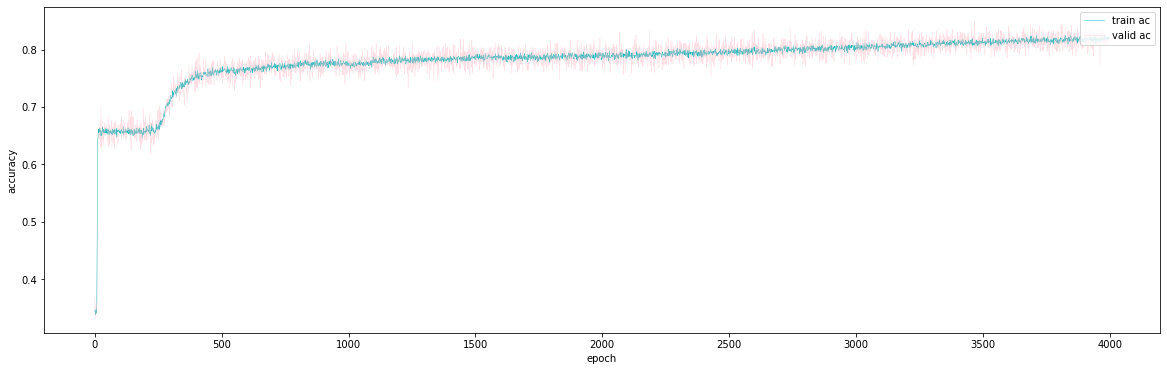

In [45]:
plt.figure(figsize = (20,6))
plt.plot(train_accuracy_list, color = 'c', linewidth = 0.5, label = 'train ac')
plt.plot(valid_accuracy_list, color = 'pink', linewidth = 0.5, alpha = 0.5, label = 'valid ac')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc = 'upper right')
plt.show()

[[ 62  32]
 [ 52 252]] 0.7889447236180904


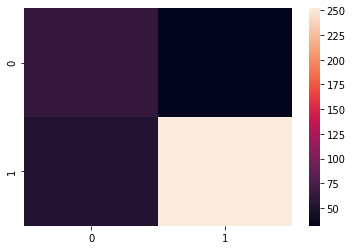

In [46]:
import seaborn as sns
net.eval()
with torch.no_grad():
    outputs = net(test_X).view(-1)
preds = torch.round(outputs).detach().numpy()
cm = confusion_matrix(test_t, preds)
print(cm)
sns.heatmap(cm)

In [47]:
print('正解率: ', accuracy_score(test_t, preds))
print('適合率: ', precision_score(test_t, preds))
print('適合率: ', recall_score(test_t, preds))
print('F値: ', f1_score(test_t, preds))

正解率:  0.7889447236180904
適合率:  0.8873239436619719
適合率:  0.8289473684210527
F値:  0.8571428571428571
